# Poisonous Mushroom Classification

### Background and Motivation

This notebook demo shows how to classify poisonous mushroom using provided tabular data. The purpose is to learn pytorch on tabular data and the standardized pipeline for a machine learning project. This task particularly is chosen because the topic is interesting to the author. 

[**Dataset**](https://www.kaggle.com/competitions/playground-series-s4e8/data?select=train.csv)

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
import sklearn
import sklearn.model_selection

from tqdm import tqdm
from ucimlrepo import fetch_ucirepo
import pprint
from pprint import pp

### Explore the mushroom dataset

First, we import necessary libraries and explore around. The goal of this section is to understand what data preprocessing steps are needed for this particular task and dataset. As per standard procedure, we load the dataset and look at the first 5 rows. It shows that there're a quite a few columns with null values, and a lot of categorical columns. Later, we should definitely look at what each category means. Before that, I'd like to see exactly how much null values are in each column. Here, the `info()` function on the dataframe comes in handy.

In [2]:
mushroom = pd.read_csv("data/mushroom.csv")
mushroom.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


It shows that most of the columns have non-null values on the scale of millions. A few are on the scale of 100k's, so we'd want to deal with that in a different way. Moreover, most of the attributes can be understood as properties of parts of the mushrooms, which makes sense to look at to classify if it's poisonous. 

Next, we'd want to look at the unique categories each categorical variable has. Here, the function `value_counts()` on a series will give us a dictionary of unique values and their counts. We randomly pick a column to check.

In [3]:
mushroom.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    3116945 non-null  int64  
 1   class                 3116945 non-null  object 
 2   cap-diameter          3116941 non-null  float64
 3   cap-shape             3116905 non-null  object 
 4   cap-surface           2445922 non-null  object 
 5   cap-color             3116933 non-null  object 
 6   does-bruise-or-bleed  3116937 non-null  object 
 7   gill-attachment       2593009 non-null  object 
 8   gill-spacing          1858510 non-null  object 
 9   gill-color            3116888 non-null  object 
 10  stem-height           3116945 non-null  float64
 11  stem-width            3116945 non-null  float64
 12  stem-root             359922 non-null   object 
 13  stem-surface          1136084 non-null  object 
 14  stem-color            3116907 non-

It seems like the categorical values don't make any sense in many cases. Most obviously, it sometimes is numerical! This is a problem. We need to look at the original definitions of these categorical variables. To do this, we noticed that the kaggle competition cited the original dataset, which provides a complete documentation of what these letters mean. Moreover, the competition webpage said that this dataset is generated by a deep learning model trained on the original dataset, which explains why the categorical variables contain garbage values. 

In [4]:
mushroom["cap-surface"].value_counts()

cap-surface
t        460777
s        384970
y        327826
h        284460
g        263729
          ...  
1.42          1
has h         1
10.83         1
8.96          1
0.87          1
Name: count, Length: 83, dtype: int64

Pretty printing the description of variables, we get a complete definition of all the possible values, which is really helpful both in cleaning the data and in interpreting the model later on. Copy pasting to form a list of sets of categories for each variable is way too much manual work, so here I downloaded the original cleaned data and got the unique value counts dictionary for each of the columns. Then I matched these columns with the columns in the kaggle dataset, replacing any column value that's not in the defined categories to NULL. 

In [5]:
# fetch dataset 
mushroom_original = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X = mushroom_original.data.features 
y = mushroom_original.data.targets 

# variable information 
pp(mushroom_original.variables.description.values)

array([None, 'bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s',
       'fibrous=f,grooves=g,scaly=y,smooth=s',
       'brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y',
       'bruises=t,no=f',
       'almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s',
       'attached=a,descending=d,free=f,notched=n',
       'close=c,crowded=w,distant=d', 'broad=b,narrow=n',
       'black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y',
       'enlarging=e,tapering=t',
       'bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?',
       'fibrous=f,scaly=y,silky=k,smooth=s',
       'fibrous=f,scaly=y,silky=k,smooth=s',
       'brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y',
       'brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y',
       'partial=p,universal=u', 'brown=n,orange=o,white=w,yellow=y',
       'none=n,one=o,two=t',


The following block of codes build the {column, unique_value} dictionary by iterating over columns in the original dataset and calling `unique()` on each of the columns. The difference between `value_counts()` and `unique()` is that `unique()` only returns the list of unique values, but not their associated counts. 

In [6]:
cols = X.columns

unique_values = {}

for col in cols:
    unique_values[col] = X[col].unique()

In [7]:
unique_values

{'cap-shape': array(['x', 'b', 's', 'f', 'k', 'c'], dtype=object),
 'cap-surface': array(['s', 'y', 'f', 'g'], dtype=object),
 'cap-color': array(['n', 'y', 'w', 'g', 'e', 'p', 'b', 'u', 'c', 'r'], dtype=object),
 'bruises': array(['t', 'f'], dtype=object),
 'odor': array(['p', 'a', 'l', 'n', 'f', 'c', 'y', 's', 'm'], dtype=object),
 'gill-attachment': array(['f', 'a'], dtype=object),
 'gill-spacing': array(['c', 'w'], dtype=object),
 'gill-size': array(['n', 'b'], dtype=object),
 'gill-color': array(['k', 'n', 'g', 'p', 'w', 'h', 'u', 'e', 'b', 'r', 'y', 'o'],
       dtype=object),
 'stalk-shape': array(['e', 't'], dtype=object),
 'stalk-root': array(['e', 'c', 'b', 'r', nan], dtype=object),
 'stalk-surface-above-ring': array(['s', 'f', 'k', 'y'], dtype=object),
 'stalk-surface-below-ring': array(['s', 'f', 'y', 'k'], dtype=object),
 'stalk-color-above-ring': array(['w', 'g', 'p', 'n', 'b', 'e', 'o', 'c', 'y'], dtype=object),
 'stalk-color-below-ring': array(['w', 'p', 'g', 'b', 'n', 

For the next step, we first iterate through columns in the dataset that are exact matches with the original dataset. We use the function `replace()` to replace any values that are not in the defined categories to NULL.

In [8]:
cols_kaggle = ['cap-shape', 'cap-surface', 'cap-color',
       'gill-attachment', 'gill-spacing', 'gill-color',
       'veil-type', 'veil-color', 'ring-type', 'spore-print-color', 'habitat']

mushroom = pd.read_csv("data/mushroom.csv")
for col in cols_kaggle:
    col_kaggle_unique = mushroom[col].unique()
    col_original_unique = unique_values[col]
    values = list(set(col_kaggle_unique)-set(col_original_unique))
    mushroom[col] = mushroom[col].replace(values, value=None)

mushroom.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    3116945 non-null  int64  
 1   class                 3116945 non-null  object 
 2   cap-diameter          3116941 non-null  float64
 3   cap-shape             2900589 non-null  object 
 4   cap-surface           976600 non-null   object 
 5   cap-color             2838299 non-null  object 
 6   does-bruise-or-bleed  3116937 non-null  object 
 7   gill-attachment       765987 non-null   object 
 8   gill-spacing          1331055 non-null  object 
 9   gill-color            2996783 non-null  object 
 10  stem-height           3116945 non-null  float64
 11  stem-width            3116945 non-null  float64
 12  stem-root             359922 non-null   object 
 13  stem-surface          1136084 non-null  object 
 14  stem-color            3116907 non-

Checking the newly cleaned dataset, we can confirm that all data in the above columns are within definition.

In [9]:
for col in cols_kaggle:
    pp(mushroom[col].unique())

array(['f', 'x', None, 'b', 'c', 's', 'k'], dtype=object)
array(['s', None, 'y', 'g', 'f'], dtype=object)
array(['u', None, 'b', 'g', 'w', 'n', 'e', 'y', 'r', 'p', 'c'],
      dtype=object)
array(['a', None, 'f'], dtype=object)
array(['c', None, 'w'], dtype=object)
array(['w', 'n', 'g', 'k', 'y', None, 'p', 'o', 'b', 'u', 'e', 'r', 'h'],
      dtype=object)
array([None, 'p'], dtype=object)
array([None, 'n', 'w', 'y', 'o'], dtype=object)
array(['f', None, 'e', 'p', 'l', 'n'], dtype=object)
array([None, 'k', 'w', 'n', 'r', 'u', 'y', 'o', 'b', 'h'], dtype=object)
array(['d', 'l', 'g', None, 'p', 'm', 'u', 'w'], dtype=object)


For the column names that don't match with the original column name, we find the column names that have the same meaning, or should have the same associated set of unique categories, and do the same thing - replace any value in the column that is outside of the set of defined category to NULL.

In [10]:
cols_mushroom = [col for col in mushroom.columns if col not in cols_kaggle]
cols_mushroom

['id',
 'class',
 'cap-diameter',
 'does-bruise-or-bleed',
 'stem-height',
 'stem-width',
 'stem-root',
 'stem-surface',
 'stem-color',
 'has-ring',
 'season']

In [11]:
cols_mushroom = ['does-bruise-or-bleed', 'stem-root','stem-surface','stem-color']
cols_original = ["bruises", "stalk-root", "stalk-surface-above-ring", "stalk-color-above-ring"]

for col_mushroom, col_original in zip(cols_mushroom, cols_original):
    col_kaggle_unique = mushroom[col_mushroom].unique()
    col_original_unique = unique_values[col_original]
    values = list(set(col_kaggle_unique)-set(col_original_unique))
    mushroom[col_mushroom] = mushroom[col_mushroom].replace(values, value=None)

Checking to see the unique column values of the cleaned dataset again, we can see that the values matches with the defined categories.

In [12]:
for col in cols_mushroom:
    pp(mushroom[col].unique())

array(['f', 't', None], dtype=object)
array([nan, 'b', 'c', 'r', None, 'e'], dtype=object)
array([None, 'y', 's', 'k', 'f'], dtype=object)
array(['w', 'o', 'n', 'y', 'e', None, 'p', 'g', 'b', 'c'], dtype=object)


Apply `info()`, `unique()` and `head()` again to look at a snapshot of the dataframe, we're now ready to deal with the missing values.

In [13]:
mushroom.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    3116945 non-null  int64  
 1   class                 3116945 non-null  object 
 2   cap-diameter          3116941 non-null  float64
 3   cap-shape             2900589 non-null  object 
 4   cap-surface           976600 non-null   object 
 5   cap-color             2838299 non-null  object 
 6   does-bruise-or-bleed  3116828 non-null  object 
 7   gill-attachment       765987 non-null   object 
 8   gill-spacing          1331055 non-null  object 
 9   gill-color            2996783 non-null  object 
 10  stem-height           3116945 non-null  float64
 11  stem-width            3116945 non-null  float64
 12  stem-root             242202 non-null   object 
 13  stem-surface          657005 non-null   object 
 14  stem-color            2983067 non-

In [14]:
mushroom["class"].unique()

array(['e', 'p'], dtype=object)

In [15]:
mushroom.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,None,w,None,None,f,f,None,d,a
1,1,p,4.51,x,None,None,f,a,c,n,...,NaN,y,o,None,None,t,None,None,d,w
2,2,e,6.94,f,s,b,f,None,c,w,...,NaN,s,n,None,None,f,f,None,l,w
3,3,e,3.88,f,y,g,f,None,None,g,...,NaN,None,w,None,None,f,f,None,d,u
4,4,e,5.85,x,None,w,f,None,None,w,...,NaN,None,w,None,None,f,f,None,g,a


### Dealing with missing values

In [16]:
mushroom.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    3116945 non-null  int64  
 1   class                 3116945 non-null  object 
 2   cap-diameter          3116941 non-null  float64
 3   cap-shape             2900589 non-null  object 
 4   cap-surface           976600 non-null   object 
 5   cap-color             2838299 non-null  object 
 6   does-bruise-or-bleed  3116828 non-null  object 
 7   gill-attachment       765987 non-null   object 
 8   gill-spacing          1331055 non-null  object 
 9   gill-color            2996783 non-null  object 
 10  stem-height           3116945 non-null  float64
 11  stem-width            3116945 non-null  float64
 12  stem-root             242202 non-null   object 
 13  stem-surface          657005 non-null   object 
 14  stem-color            2983067 non-

First we take a look at the distribution of numerical variables.

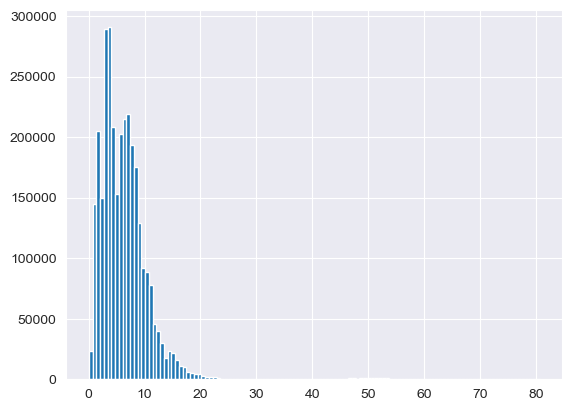

In [17]:
sns.set_style("darkgrid")
plt.hist(mushroom["cap-diameter"], bins=120)
plt.show()

In [18]:
mushroom["cap-diameter"] = mushroom["cap-diameter"].fillna(stat.median(mushroom["cap-diameter"]))
mushroom["cap-diameter"].info(show_counts=True)

<class 'pandas.core.series.Series'>
RangeIndex: 3116945 entries, 0 to 3116944
Series name: cap-diameter
Non-Null Count    Dtype  
--------------    -----  
3116945 non-null  float64
dtypes: float64(1)
memory usage: 23.8 MB


We can see that even the columns that have the lower end of non-null counts still have around 200k records. So we keep most records and fill in the null values with a seperate "unknown" value. The reason why I chose to not fill null values with most frequent category is because some of the columns have a large portion of null values, and thus fill null values with most frequent value could really skew the distribution.

In [19]:
mushroom.columns

Index(['id', 'class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [20]:
cols_cat = [ 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-root', 'stem-surface', 'stem-color',
       'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season']

for col in cols_cat:
    mushroom[col] = mushroom[col].fillna("unknown")

In [21]:
mushroom.drop('veil-type', axis=1, inplace=True) # dropping veil-type because it only has 2 non-null value
mushroom.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    3116945 non-null  int64  
 1   class                 3116945 non-null  object 
 2   cap-diameter          3116945 non-null  float64
 3   cap-shape             3116945 non-null  object 
 4   cap-surface           3116945 non-null  object 
 5   cap-color             3116945 non-null  object 
 6   does-bruise-or-bleed  3116945 non-null  object 
 7   gill-attachment       3116945 non-null  object 
 8   gill-spacing          3116945 non-null  object 
 9   gill-color            3116945 non-null  object 
 10  stem-height           3116945 non-null  float64
 11  stem-width            3116945 non-null  float64
 12  stem-root             3116945 non-null  object 
 13  stem-surface          3116945 non-null  object 
 14  stem-color            3116945 non-

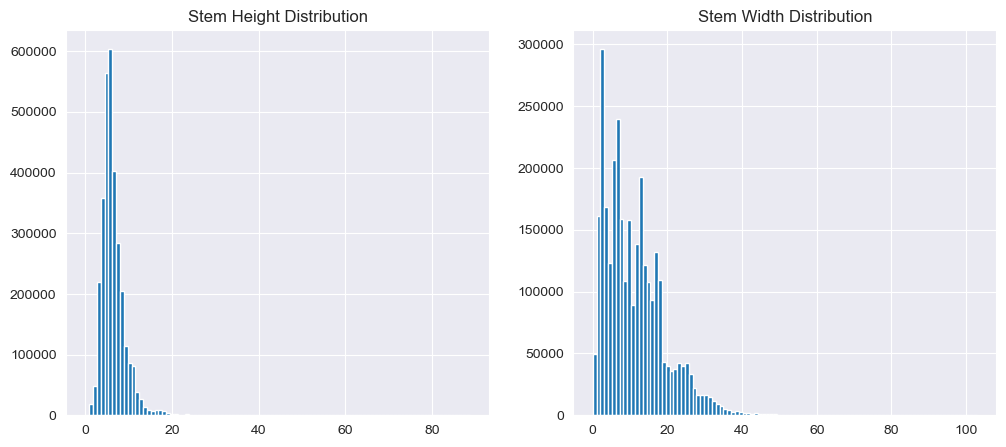

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(mushroom["stem-height"], bins=100)
axs[0].set_title("Stem Height Distribution")
axs[1].hist(mushroom["stem-width"], bins=100)
axs[1].set_title("Stem Width Distribution")

plt.show()

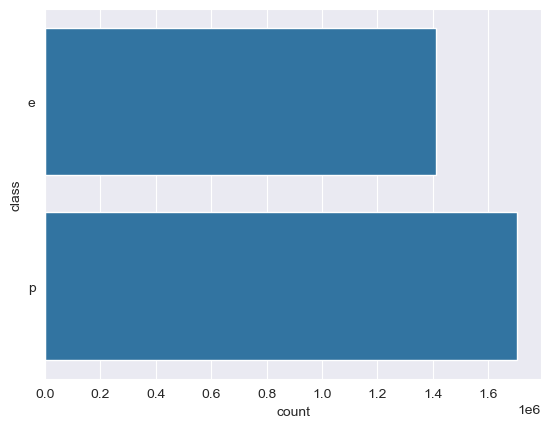

In [23]:
sns.countplot(mushroom["class"])
plt.show()

In [24]:
unique_value_counts = mushroom["cap-surface"].value_counts()
list(unique_value_counts.index), list(unique_value_counts.values)

(['unknown', 's', 'y', 'g', 'f'], [2140345, 384970, 327826, 263729, 75])

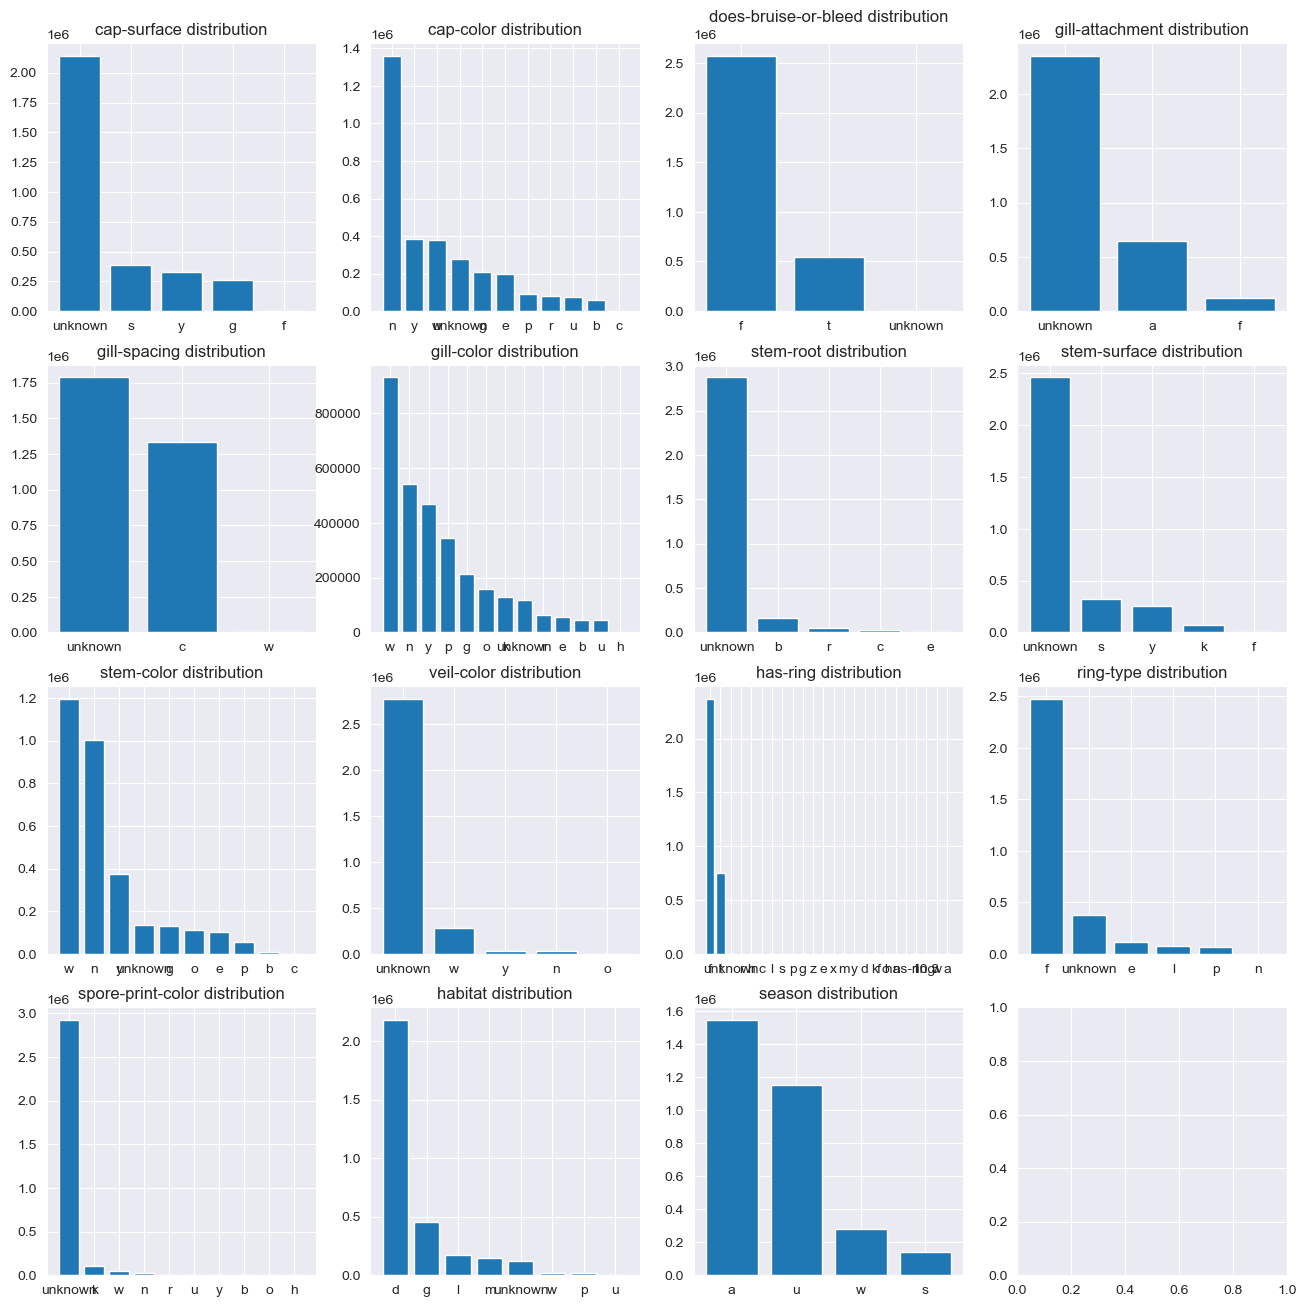

In [25]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for i in range(4):
    for j in range(4):
        if i == 3 & j == 3: break
        col = cols_cat[i*4+j+1]
        unique_value_counts = mushroom[col].value_counts()
        axs[i][j].bar(list(unique_value_counts.keys()), list(unique_value_counts.values))
        axs[i][j].set_title(f"{col} distribution")

plt.show()

Looks like some of the columns are better being dropped because there're just too many unknowns. We'll try keeping them first, and then try dropping them.

### Standardzing the numerical variables and partition the dataset into train/val data

To standardize the numerical variables, we mean center it and divide it by its standard deviation.

In [26]:
cols_numerical = ['cap-diameter', 'stem-height', 'stem-width']

for col in cols_numerical:
    mean = mushroom[col].mean()
    std_dev = stat.stdev(mushroom[col])
    mushroom[col] = (mushroom[col] - mean)/std_dev

mushroom.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-width,stem-root,stem-surface,stem-color,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,0.534604,f,s,u,f,a,c,w,...,0.523282,unknown,unknown,w,unknown,f,f,unknown,d,a
1,1,p,-0.386406,x,unknown,unknown,f,a,c,n,...,-0.577333,unknown,y,o,unknown,t,unknown,unknown,d,w
2,2,e,0.135285,f,s,b,f,unknown,c,w,...,-0.151169,unknown,s,n,unknown,f,f,unknown,l,w
3,3,e,-0.521659,f,y,g,f,unknown,unknown,g,...,-0.571157,unknown,unknown,w,unknown,f,f,unknown,d,u
4,4,e,-0.098724,x,unknown,w,f,unknown,unknown,w,...,-0.345104,unknown,unknown,w,unknown,f,f,unknown,g,a


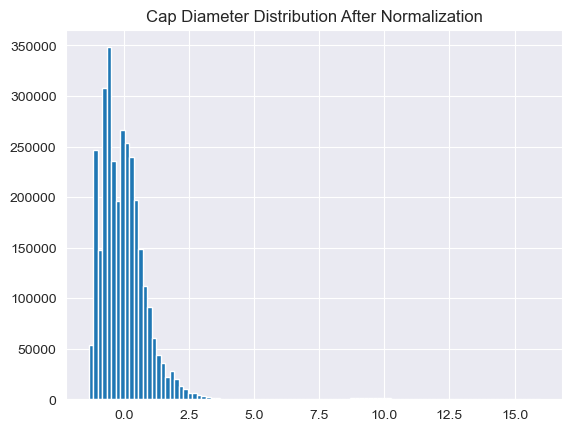

In [27]:
plt.hist(mushroom['cap-diameter'], bins=100)
plt.title("Cap Diameter Distribution After Normalization")
plt.show()

Because this dataset is rather large, we can only take 5% records as validation set and it should be enough.

In [36]:
val_size = 0.05
train_size = 1 - val_size
df_train, df_test = sklearn.model_selection.train_test_split(mushroom, train_size=train_size, random_state=1)
train_stats = df_train.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
id,2961097.0,1.558405e+06,899777.275593,0.000000,779151.000000,1.558291e+06,2.337603e+06,3.116944e+06
cap-diameter,2961097.0,-7.723960e-05,1.000187,-1.348207,-0.641884,-1.201932e-01,4.143792e-01,1.596421e+01
stem-height,2961097.0,1.301282e-04,1.000269,-2.351448,-0.621661,-1.734725e-01,3.932456e-01,3.051080e+01
stem-width,2961097.0,-5.237426e-05,1.000004,-1.377780,-0.763857,-1.857562e-01,5.529278e-01,1.133302e+01


The distribution roughly preserved.

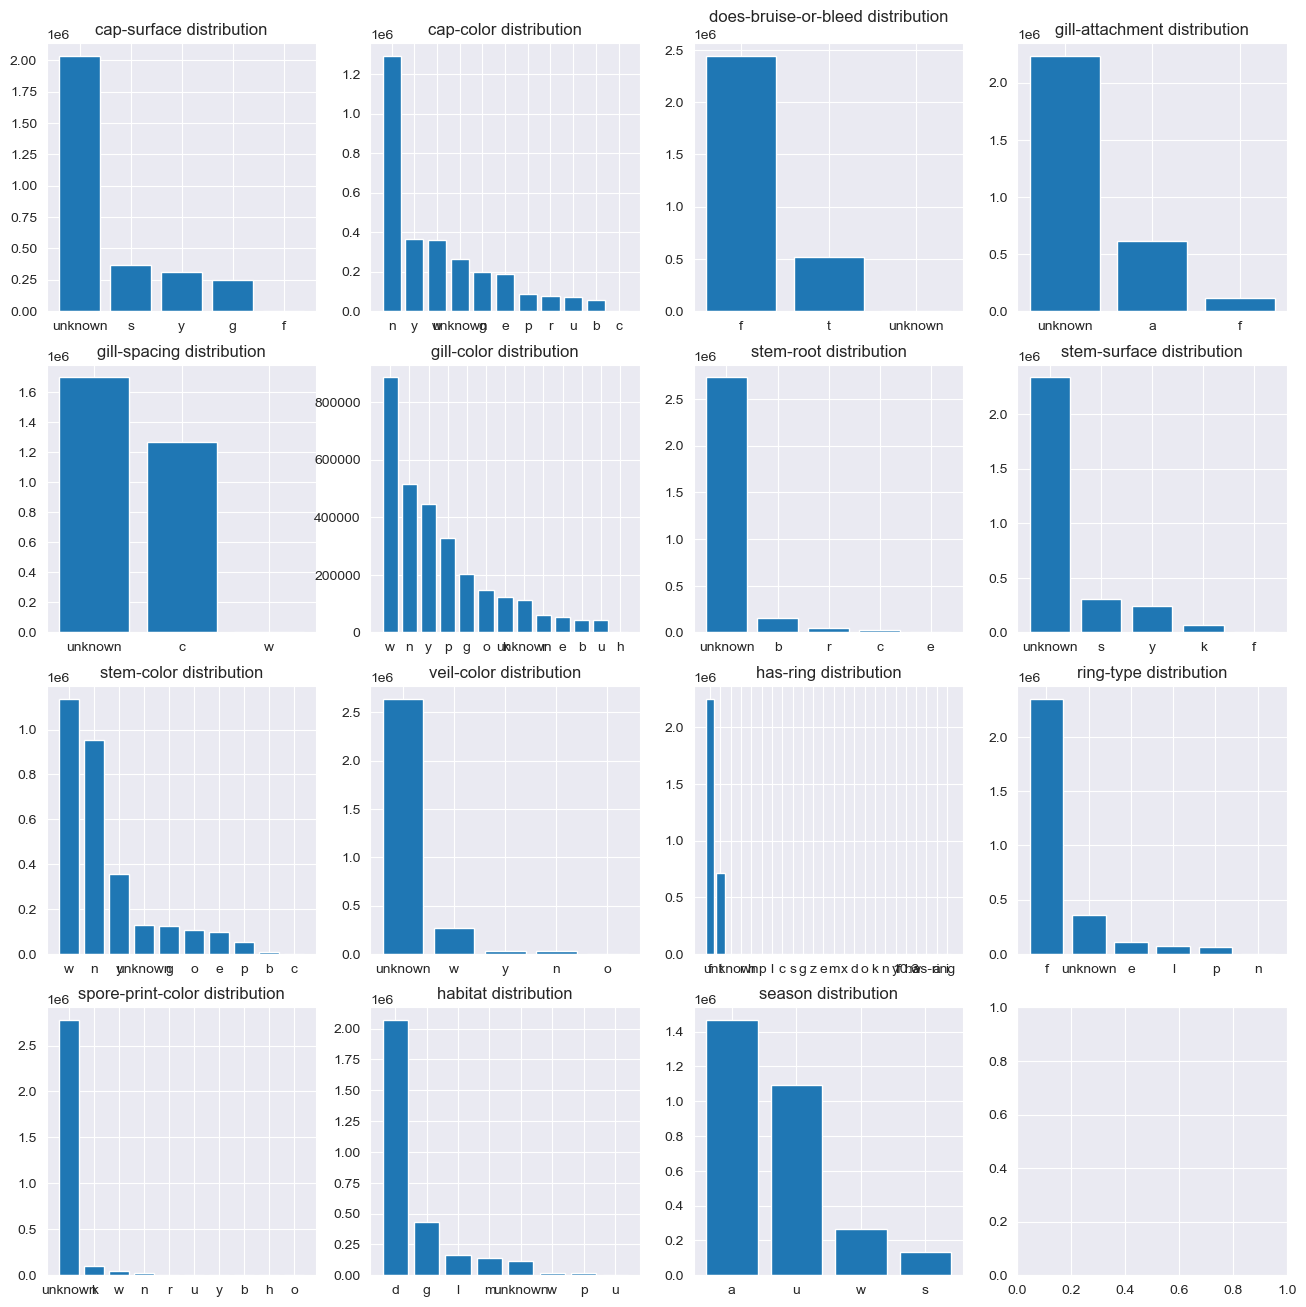

In [37]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for i in range(4):
    for j in range(4):
        if i == 3 & j == 3: break
        col = cols_cat[i*4+j+1]
        unique_value_counts = df_train[col].value_counts()
        axs[i][j].bar(list(unique_value_counts.keys()), list(unique_value_counts.values))
        axs[i][j].set_title(f"{col} distribution")

plt.show()

### Convert Categorical Variables to Dummy Variables / One-hot Encodings

In [38]:
df_train_dummies = pd.get_dummies(df_train, columns = cols_cat, dtype=int)
df_test_dummies = pd.get_dummies(df_test, columns = cols_cat, dtype=int)
mushroom_dummies = pd.get_dummies(mushroom, columns = cols_cat, dtype=int)
df_train_dummies.head()

,id,class,cap-diameter,stem-height,stem-width,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,...,habitat_l,habitat_m,habitat_p,habitat_u,habitat_unknown,habitat_w,season_a,season_s,season_u,season_w
1811010,1811010,p,-1.024028,-0.888352,-1.203608,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
191056,191056,p,-0.568891,1.511866,-0.631684,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2024467,2024467,p,-0.596800,-0.510540,-0.684800,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2317180,2317180,p,-0.528100,0.804394,-0.540275,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2231687,2231687,e,-0.279062,-0.369787,-0.650213,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Now the dataset is ready! Finally, let's store it backed to our folder for further loading and using.

In [39]:
df_train.to_csv("data/train.csv", index=False)
df_test.to_csv("data/val.csv", index=False)

In [40]:
mushroom.to_csv("data/mushroom_dummies.csv", index=False)

In [41]:
df_train_dummies.to_csv("data/train_dummies.csv", index=False)

In [42]:
df_test_dummies.to_csv("data/val_dummies.csv", index=False)